# **Step 1:** Import packages

In [1]:
import os, shutil, pickle
from DefChar import FeatureExtraction as FE
from DefChar import MaskConverter as MC
import json
import numpy as np
import time
import cv2
from tqdm import tqdm
from math import *
from matplotlib import pyplot as plt
import cv2

# **Step 2:** DefChar extraction and build the Datastore

In [2]:
# [User Action Required] Put the folder path of the original images
Image_folder = "./Sample Data/images/"
# [User Action Required] Put the folder path of the corresponding annotated masks
Mask_folder = "./Sample Data/masks/"

# Clean folder for DefChar extraction
if os.path.exists("./.images_temp"):
    shutil.rmtree("./.images_temp")
    os.mkdir('./.images_temp')

if os.path.exists("./crop_images/"):
    shutil.rmtree("./crop_images/")

# Process and normalise masks
data = {}
for i in os.listdir(Image_folder):
    gt_c, gt_m, gt_g = MC.process_mask(Mask_folder+i.split(".")[0]+".png", True, True)
    data[i] = {}
    data[i]["polygons"] = gt_c
    data[i]["type"] = gt_g
    
# Extract DefChars based on images and masks
# label will the datastore as a dictionary type
FE.initLabel()
FE.Label_ = {}
FE.checkImages(Image_folder)
FE.readLabel(data)
label = FE.loadData(crop_pad=0.25, size_percent=True)
label = FE.featureExtract(outside="full", original=True, norm=True)

# Store the extracted DefChars into a pickle file
with open("./defchar.pkl", "wb") as pfile:
    pickle.dump(label, pfile)
    pfile.close()

# Copy the cropped images into a folder
shutil.copytree("./.images_temp/", "./crop_images/")

Loading Images:   0%|                                   | 0/105 [00:00<?, ?it/s]/home/edgetrier/Work/ImgRetreival-DefChars/DefChar/FeatureExtraction.py:277: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(i != poly1):
Feature Extraction: 100%|█████████████████████| 624/624 [00:06<00:00, 89.43it/s]


'./crop_images/'

# **Step 3**: Retrieve images from a new image and mask
#### **Please note:** load the pickle file if you did not extract DefChars from Step 2.

In [26]:
# [User Action Required] Put the folder path of the original images
Test_image = "./Sample Data/test_image.jpg"
# [User Action Required] Put the folder path of the corresponding annotated masks
Test_mask = "./Sample Data/test_mask.png"

# Clean folder
if os.path.exists("./test_crop"):
    shutil.rmtree("./test_crop")

os.mkdir("./test_crop")

# Process and normalise mask
gt_c, gt_m, gt_g = MC.process_mask(Test_mask, True, True)
print("Found %d irregular patterns in the image." % (len(gt_c)))

# Extract the DefChars of all irregular patterns contained in the image.
test_defchars = []
c = 1
for i in gt_c:
    test_defchar = FE.extractSingleDefect(Test_image, i, gt_c, 
                           size_norm=label["1_1"]["norm_size"], 
                           edge_norm=label["1_1"]["norm_edge"])
    test_defchars.append(test_defchar)
    shutil.copyfile("./.images_temp/-1.jpg", "./test_crop/"+str(c)+".jpg")
    c += 1

feature = ['out_hue_avg',
           'out_hue_mode',
           'out_hue_range',
           'out_hue_uni',
           'out_sat_avg',
           'out_sat_mode',
           'out_sat_range',
           'out_sat_uni',
           'out_brt_avg',
           'out_brt_mode',
           'out_brt_range',
           'out_brt_uni',
           'size',
           'asp_ratio',
           'distance',
           'coverage',
           'deg_avg',
           'deg_mode',
           'edge',
           'sc_edge_ratio',
           'sc_follow_turn',
           'sc_reverse_turn',
           'sc_small_turn',
           'hue_avg',
           'hue_mode',
           'hue_range',
           'hue_uni',
           'sat_avg',
           'sat_mode',
           'sat_range',
           'sat_uni',
           'brt_avg',
           'brt_mode',
           'brt_range',
           'brt_uni',
           'hue_outin',
           'sat_outin',
           'brt_outin']

def manhattan(test,target):
    return sum(abs(a-b) for a,b in zip(test,target))

def search(index=1, top=10):
    # If index is out of list
    if index > len(test_defchars):
        raise IndexError("Index is larger than the test DefChar list (maximum index: %d)"%(len(test_defchars)))
    
    # Get the DefChar of query image
    test_dc = [test_defchars[index-1][f] for f in feature]
    
    # Caclulate similarity for each irregular pattern in the query image
    similarity = []
    for i in tqdm(label, desc="Retrieve Irregular patterns"):
        re_dc = [label[i][f] for f in feature]
        similarity.append([i, manhattan(test_dc, re_dc)])
    # Rank results
    similarity = sorted(similarity, key=lambda x:x[-1])
    if top > 0:
        similarity = similarity[:top]
    
    # Show images and rank results
    print("Query Irregular Pattern")
    s_img = cv2.cvtColor(cv2.imread("./test_crop/"+str(index)+".jpg"), cv2.COLOR_BGR2RGB)
    s_fig = plt.imshow(s_img)
    plt.show()
    co = 1
    for i in similarity:
        print("Rank: %d - Irregular Pattern ID: %s - Similarity: %0.4f"%(co, i[0], i[-1]))
        s_img = cv2.cvtColor(cv2.imread("./crop_images/"+str(i[0])+".jpg"), cv2.COLOR_BGR2RGB)
        s_fig = plt.imshow(s_img)
        plt.show()
        co += 1

print("""Please run the next cell to retrieve the similar irregular patterns.
parameter explanation:
index: integer - retrieve irregular patterns based on the n-th irregular pattern from the test image
top: integer - show top n results (0 -> show all results)
""")

Found 3 irregular patterns in the image.
Please run the next cell to retrieve the similar irregular patterns.
parameter explanation:
index: integer - retrieve irregular patterns based on the n-th irregular pattern from the test image
top: integer - show top n results (0 -> show all results)



Retrieve Irregular patterns: 100%|█████████| 624/624 [00:00<00:00, 59824.13it/s]

Query Irregular Pattern


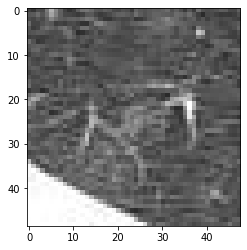

Rank: 1 - Irregular Pattern ID: 88_3 - Similarity: 1.2045


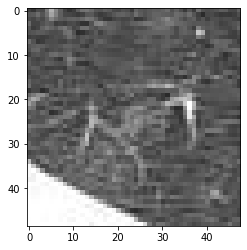

Rank: 2 - Irregular Pattern ID: 74_11 - Similarity: 1.9746


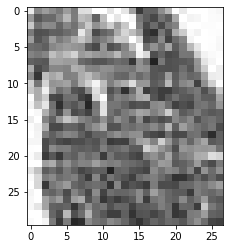

Rank: 3 - Irregular Pattern ID: 1_5 - Similarity: 2.0339


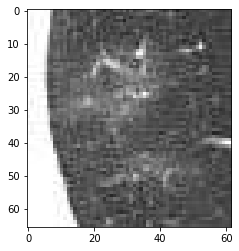

Rank: 4 - Irregular Pattern ID: 102_4 - Similarity: 2.1842


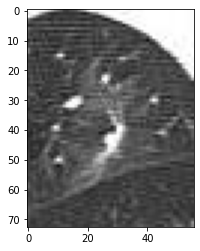

Rank: 5 - Irregular Pattern ID: 95_6 - Similarity: 2.2052


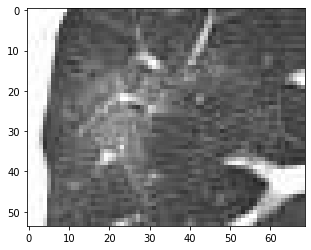

Rank: 6 - Irregular Pattern ID: 68_4 - Similarity: 2.2230


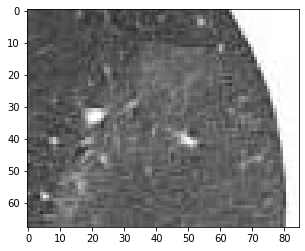

Rank: 7 - Irregular Pattern ID: 74_8 - Similarity: 2.2233


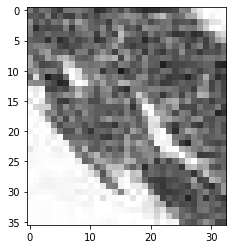

Rank: 8 - Irregular Pattern ID: 65_13 - Similarity: 2.3555


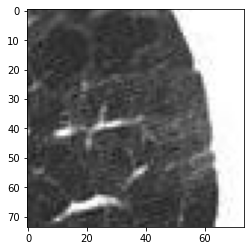

Rank: 9 - Irregular Pattern ID: 6_2 - Similarity: 2.3912


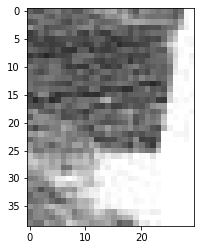

Rank: 10 - Irregular Pattern ID: 103_5 - Similarity: 2.3975


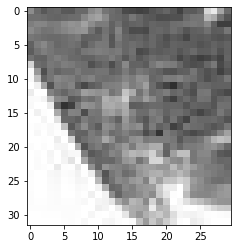

In [29]:
search(3, 10)